In [1]:
import os
import torch
import cv2
from torchvision.datasets import CocoDetection
from simple_copy_paste.simple_copy_paste import copy_paste_class
from torchvision import tv_tensors
import numpy as np
from torchvision.io import read_image

from torchvision.transforms import functional as F
import torchvision.transforms as T


from torchvision.transforms import InterpolationMode

min_keypoints_per_image = 10


def _count_visible_keypoints(anno):
    return sum(sum(1 for v in ann["keypoints"][2::3] if v > 0) for ann in anno)


def _has_only_empty_bbox(anno):
    return all(any(o <= 1 for o in obj["bbox"][2:]) for obj in anno)


def has_valid_annotation(anno):
    # if it's empty, there is no annotation
    if len(anno) == 0:
        return False
    # if all boxes have close to zero area, there is no annotation
    if _has_only_empty_bbox(anno):
        return False
    # keypoints task have a slight different critera for considering
    # if an annotation is valid
    if "keypoints" not in anno[0]:
        return True
    # for keypoint detection tasks, only consider valid images those
    # containing at least min_keypoints_per_image
    if _count_visible_keypoints(anno) >= min_keypoints_per_image:
        return True

    return False


@copy_paste_class
class CocoDetectionCP(CocoDetection):
    def __init__(self, root, annFile, transforms):
        super(CocoDetectionCP, self).__init__(root, annFile, None, None, transforms)

        # filter images without detection annotations
        ids = []
        for img_id in self.ids:
            ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=None)
            anno = self.coco.loadAnns(ann_ids)
            if has_valid_annotation(anno):
                ids.append(img_id)
        self.ids = ids

    def collate_fn(_, batch):
        return tuple(zip(*batch))

    def load_example(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        target = self.coco.loadAnns(ann_ids)

        path = self.coco.loadImgs(img_id)[0]["file_name"]
        image = cv2.imread(os.path.join(self.root, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # convert all of the target segmentations to masks
        # bboxes are expected to be (y1, x1, y2, x2, category_id)
        masks = []
        bboxes = []
        for ix, obj in enumerate(target):
            masks.append(self.coco.annToMask(obj))
            bboxes.append(obj["bbox"] + [obj["category_id"]] + [ix])

        # pack outputs into a dict
        output = {"image": image, "masks": masks, "bboxes": bboxes}

        return self.transforms(**output)


class CustomCocoDetection(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super().__init__(img_folder, ann_file, transforms)
        self.img_folder = img_folder

    @staticmethod
    def collate_fn(batch):
        images = list(image for image, _ in batch)
        targets = list(target for _, target in batch)
        return images, targets

    def __getitem__(self, index):
        image_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        target = self.coco.loadAnns(ann_ids)

        # Process target to match your desired format
        output_target = {}
        output_target["boxes"] = []
        output_target["labels"] = []
        output_target["masks"] = []

        for obj in target:
            # Convert boxes to x1, y1, x2, y2
            x, y, w, h = obj["bbox"]
            x2 = x + w
            y2 = y + h
            output_target["boxes"].append(torch.tensor([x, y, x2, y2]).float())

            output_target["labels"].append(obj["category_id"])

            # Assuming masks are RLE encoded
            mask = self.coco.annToMask(obj)
            output_target["masks"].append(mask)

        path = self.coco.loadImgs(image_id)[0]["file_name"]
        image = read_image(os.path.join(self.img_folder, path))
        image = tv_tensors.Image(image)
        # Convert to tensors
        output_target["boxes"] = torch.tensor(
            np.array(output_target["boxes"])
        ).float()  # Ensure float for bounding boxes
        output_target["labels"] = torch.tensor(output_target["labels"]).long()
        output_target["masks"] = torch.tensor(np.array(output_target["masks"]))
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(
            output_target["boxes"], format="XYXY", canvas_size=F.get_size(image)
        )
        target["masks"] = tv_tensors.Mask(output_target["masks"])
        target["labels"] = output_target["labels"]

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

/Users/erikriise/anaconda3/envs/DiffAug/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
def get_transform(image=True):
    transforms = []
    transforms.append(T.ToTensor())
    if image:
        transforms.append(T.Resize((256, 256), InterpolationMode.BILINEAR))
    else:
        transforms.append(T.Resize((256, 256), InterpolationMode.NEAREST))
    return T.Compose(transforms)

In [59]:
from PIL import Image


class CustomCocoSegmentation(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms_im=None, transforms_mask=None):
        super().__init__(img_folder, ann_file, transforms_im, transforms_mask)
        self.img_folder = img_folder
        self.transforms_im = transforms_im
        self.transforms_mask = transforms_mask

    def __getitem__(self, index):
        image_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=image_id)

        # Load annotation details
        annotations = [self.coco.loadAnns([ann_id])[0] for ann_id in ann_ids]

        path = self.coco.loadImgs(image_id)[0]["file_name"]
        image = Image.open(os.path.join(self.img_folder, path)).convert("RGB")

        mask = np.zeros((image.size[1], image.size[0]))
        for obj in annotations:
            segmentation_mask = self.coco.annToMask(obj)
            mask[segmentation_mask == 1] = obj["category_id"]

        if self.transforms is not None:
            image_t = self.transforms_im(image)
            target = self.transforms_mask(mask)

        return image_t.squeeze(), target.squeeze()

In [60]:
data = CustomCocoSegmentation(
    img_folder="data/val2017",
    ann_file="bear_subset_annotations_val.json",
    transforms_im=get_transform(image=True),
    transforms_mask=get_transform(image=False),
)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [58]:
from matplotlib import pyplot as plt


# plot with bboxes and masks
def plot_image(image, target):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image.permute(1, 2, 0))

    for box, mask in zip(target["boxes"], target["masks"]):
        x, y, x2, y2 = box
        rect = plt.Rectangle(
            (x, y), x2 - x, y2 - y, fill=False, edgecolor="red", linewidth=2
        )
        ax.add_patch(rect)

        mask = mask.numpy()
        mask = np.ma.masked_where(mask == 0, mask)
        ax.imshow(mask, alpha=0.5, cmap="viridis")

    plt.show()


plot_image(*data[4])

TypeError: __call__() takes 2 positional arguments but 3 were given

In [45]:
def get_transform():
    transforms = []
    transforms.append(T.Resize((256, 256)), interpolation=)
    return T.Compose(transforms)

In [70]:
from torchvision.datasets import CocoDetection, wrap_dataset_for_transforms_v2

dataset = CustomCocoSegmentation(
    img_folder="data/val2017",
    ann_file="bear_subset_annotations_val.json",
    transforms=get_transform(),
)

# dataset = CocoDetection(
#     root="data/val2017",
#     annFile="bear_subset_annotations_val.json",
#     transforms=get_transform(),
# )
dataset = wrap_dataset_for_transforms_v2(dataset)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [72]:
dataset[0]

AttributeError: 'str' object has no attribute 'items'

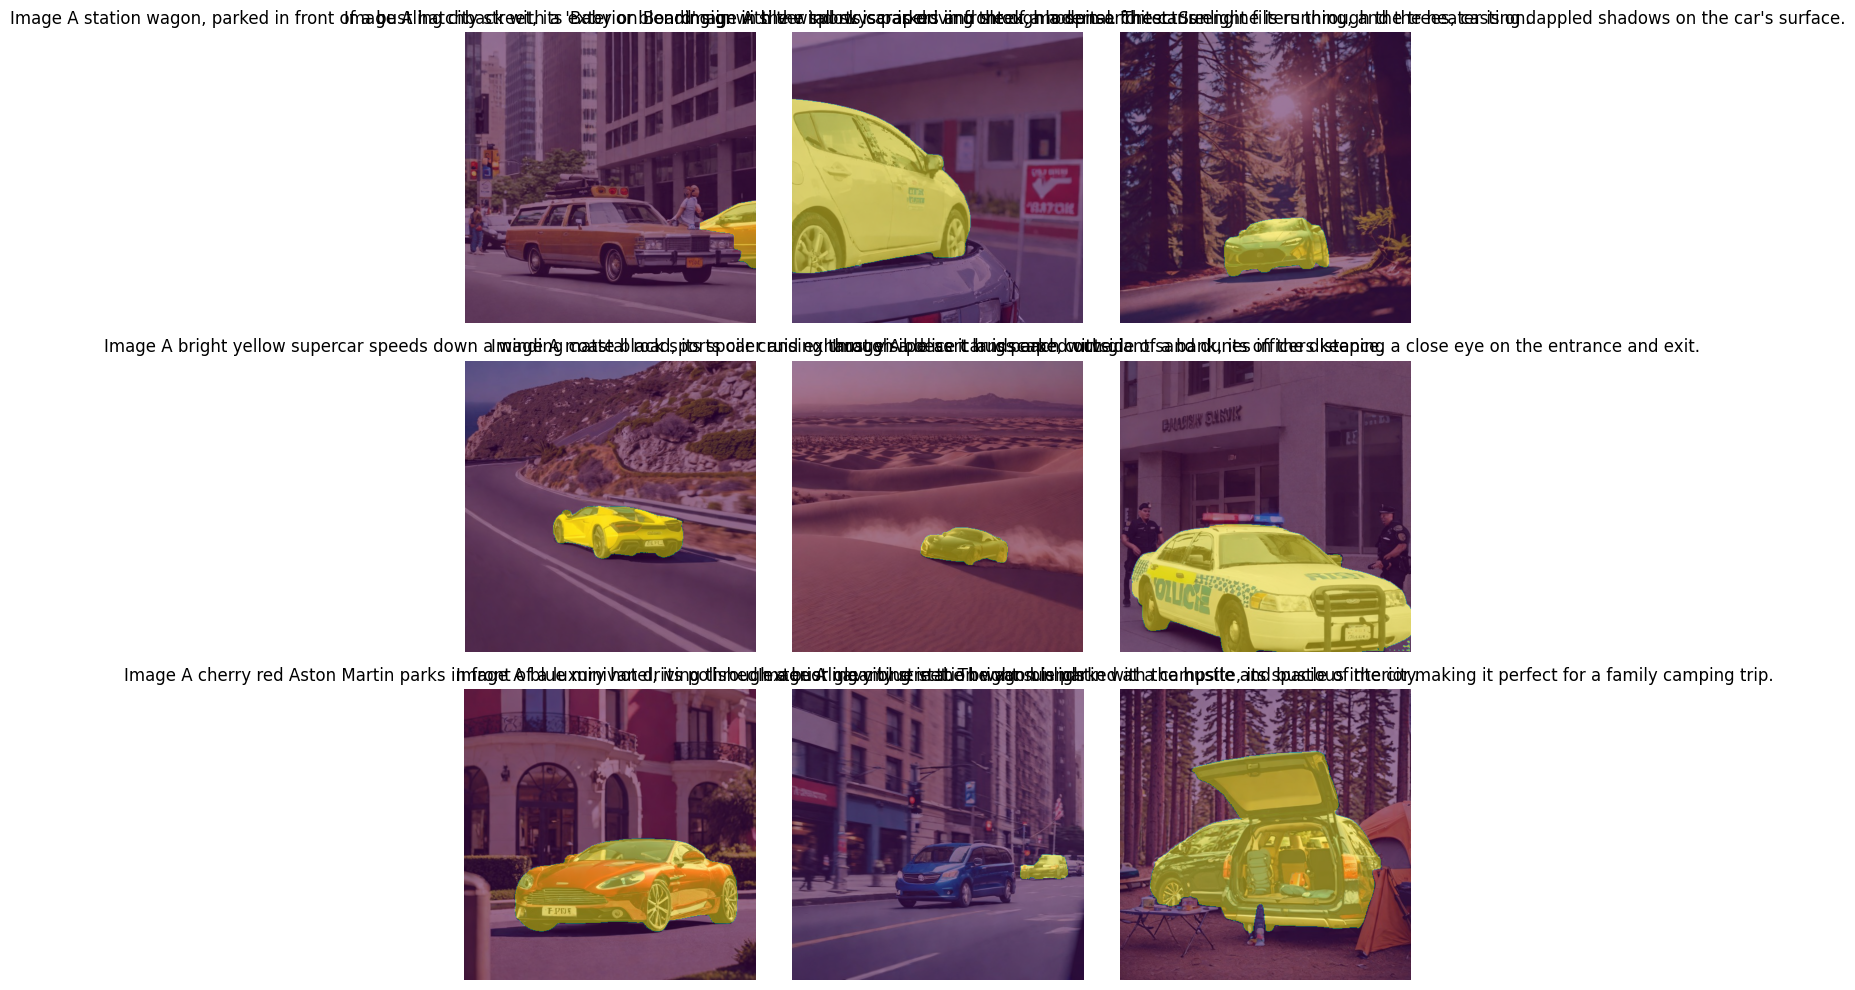

In [5]:
import os
import zlib
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import json

def flatten(l):
    return [item for sublist in l for item in sublist]

def read_and_decompress(file):
    # Read the compressed mask from the pickle file
    with open(file, "rb") as f:
        compressed_mask = pickle.load(f)
    # Decompress the mask
    decompressed_mask = zlib.decompress(compressed_mask)
    # Convert the decompressed mask to numpy array
    mask = np.frombuffer(decompressed_mask, dtype=np.bool_)
    n = np.sqrt(len(mask)).astype(int)
    mask = mask.reshape((n, n))
    return mask

# Define the grid size
grid_size = (3, 3)

# Define the image and mask paths
image_folder = "data-llm/car"
mask_folder = "data-llm/car"

# Create a figure and axes for the grid
fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))

descs = json.load(open("noun_descriptions1.json"))

# Iterate over the grid and plot images with masks
for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        # Calculate the index of the image
        index = i * grid_size[1] + j
        # Construct the image and mask paths
        rand = np.random.randint(0, 999)
        img_path = os.path.join(image_folder, f"img_{rand}.jpg")
        mask_path = os.path.join(mask_folder, f"mask_{rand}.pkl")
        
        # Check if the image and mask files exist
        if os.path.exists(img_path) and os.path.exists(mask_path):
            # Read and decompress the mask
            mask = read_and_decompress(mask_path)
            
            # Open and convert the image to RGB
            image = Image.open(img_path).convert("RGB")
            
            # Plot the image with the mask overlay
            axs[i, j].imshow(image)
            axs[i, j].imshow(mask, alpha=0.5, cmap="viridis")
            axs[i, j].set_title(f"Image {flatten(descs['car'])[rand]}")
        
        # Remove axis labels
        axs[i, j].axis("off")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [61]:
# in data-llm/boat delete all masks that does not have corresponding image
import os
import shutil

image_folder = "data-llm/bus"
mask_folder = "data-llm/bus"

# Iterate over the mask files
for mask_file in os.listdir(mask_folder):
    # Construct the image path
    image_file = os.path.join(image_folder, mask_file.replace("mask", "img").replace(".pkl", ".jpg"))
    
    # Check if the corresponding image file exists
    if not os.path.exists(image_file):
        # Remove the mask file
        os.remove(os.path.join(mask_folder, mask_file))



# Check the number of mask files
len(os.listdir(mask_folder))



1832